<a href="https://colab.research.google.com/github/bayrameda/MrAP/blob/main/MrAP_FB15K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter==2.0.4

  Created wheel for torch-scatter: filename=torch_scatter-2.0.4-cp36-cp36m-linux_x86_64.whl size=11357700 sha256=12a2e2174a6068841178cd2ffbcac2f1a84cee6ecaa7f3c75cab32422392a41c
  Stored in directory: /root/.cache/pip/wheels/fb/28/28/458ddcee4849d5f8a14dd1be1e957d2e8b2955e8c96b07a12d
Successfully built torch-scatter


In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data Read

In [ ]:
ent_100 = pd.read_csv('data/train_100')
ent_80 = pd.read_csv('data/train_80')
ent_50 = pd.read_csv('data/train_50')
ent_20 = pd.read_csv('data/train_20')
ent_dev = pd.read_csv('data/dev')
ent_test = pd.read_csv('data/test')

entities = pd.concat([ent_100, ent_dev, ent_test], ignore_index=True)
entities.set_axis(['node', 'attribute', 'numeric'], axis=1, inplace=True)

triples = pd.read_csv('data/triples')

In [ ]:
from utils import extract_edges_FB, estimate_params, drop_sym, reduce_to_singles, performance

In [ ]:
dates = ['people.person.date_of_birth',
          'film.film.initial_release_date',
          'organization.organization.date_founded',
          'location.dated_location.date_founded',
          'people.deceased_person.date_of_death']
corr_attributes = [dates,
                    ['people.person.weight_kg','people.person.height_meters'],
                    ['location.geocode.latitude'],
                    ['location.geocode.longitude'],
                    ['location.location.area','topic_server.population_number']]

In [ ]:
edge_list = []
relations = []
for attributes in corr_attributes:
  entities_ofint = entities[entities.attribute.isin(attributes)]
  edge_ofint, rel_ofint = extract_edges_FB(triples, entities_ofint)
  edge_list = edge_list + edge_ofint
  relations = relations + rel_ofint

## Stats

In [ ]:
entity_stat = pd.DataFrame(columns=['count','min', 'mean', 'max'])
attributes = entities['attribute'].unique().tolist()
for key in attributes:
  numerics = entities[entities['attribute']==key]['numeric']
  entity_stat.loc[key] = [len(numerics), numerics.min(),numerics.mean(),numerics.max()]
entity_stat

,count,min,mean,max
location.geocode.longitude,3192.0,-175.200000,-3.619346e+01,1.792167e+02
location.geocode.latitude,3190.0,-90.000000,3.715311e+01,7.761361e+01
people.person.date_of_birth,4406.0,-383.000000,1.939987e+03,1.999917e+03
people.deceased_person.date_of_death,1214.0,-322.000000,1.961837e+03,2.015583e+03
people.person.height_meters,2855.0,1.346000,1.760869e+00,2.180000e+00
film.film.initial_release_date,1853.0,1927.083333,1.996291e+03,2.013500e+03
organization.organization.date_founded,1228.0,1088.000000,1.892719e+03,2.013000e+03
topic_server.population_number,1920.0,1.000000,5.982174e+06,3.130439e+09
location.location.area,2154.0,0.004047,4.658744e+05,1.652500e+08
location.dated_location.date_founded,917.0,-2999.000000,1.750595e+03,2.011583e+03


### Multi-relational graph stats

In [ ]:
print('Number of attribute types = ', entities['attribute'].nunique())
N = len(entities)
print('Total number of numerical facts = ', N)
print('Total number of entities = ',entities.node.nunique())
print('Total number of triple facts = ', len(triples))
print('Number of relation types = ',triples.relation.nunique())
print('Number of regression models = ', len(relations))
asym_edge_list = drop_sym(edge_list)
print('Number of message passing paths =', len(np.concatenate(asym_edge_list)))

Number of attribute types =  11
Total number of numerical facts =  23154
Total number of entities =  10054
Total number of triple facts =  118747
Number of relation types =  114
Number of regression models =  310
Number of message passing paths = 180688


In [ ]:
attribute_labels = entities.attribute.values # corresponding entity labels of the nodes
x = entities.numeric.values.copy() # ordering of entities is compatible with the node ordering in triples

### Histogram demo

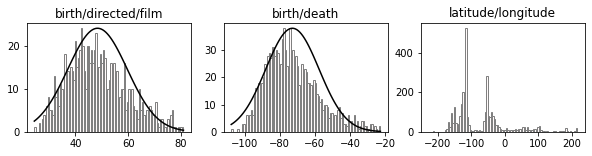

In [ ]:
normal = lambda x, m, std, peak : peak*np.exp(-1/2*(x-m)**2/std**2)

def hist_plot(diff_pair, rel):
  bin_vals, bin_edges, _  = plt.hist(diff_pair, bins=100, color='snow', ec= 'grey');
  plt.plot(bin_edges, normal(bin_edges,diff_pair.mean(),diff_pair.std(),max(bin_vals)), 'k')
  plt.title(rel);

plt.figure(figsize=(10, 2));

pairs = edge_list[relations.index('/film/director/film')]
x_pairs = x[pairs]
diff_pair = x_pairs[:,1] - x_pairs[:,0]
plt.subplot(1,3,1)
hist_plot(diff_pair, 'birth/directed/film')

pairs = edge_list[relations.index('people.deceased_person.date_of_death_coupling')]
x_pairs = x[pairs]
diff_pair = x_pairs[:,1] - x_pairs[:,0]
plt.subplot(1,3,2)
hist_plot(diff_pair, 'birth/death')

lat_ent = entities[entities['attribute']=='location.geocode.latitude']
long_ent = entities[entities['attribute']=='location.geocode.longitude']
diff_pair = [long_ent[long_ent.node== node]['numeric'].item()- lat_ent[lat_ent.node== node]['numeric'].item() for node in lat_ent.node.to_list() if node in long_ent.node.to_list()]
diff_pair = np.array(diff_pair)
plt.subplot(1,3,3)
plt.hist(diff_pair, bins=100, color='snow', ec= 'grey');
plt.title('latitude/longitude');


#plt.savefig('histograms.pdf')

# Performances

In [ ]:
def indices(entities_interest): #get the indicies of the entities of interest wrt x ordering
  return [entities[(entities.node == row[0]) & (entities.attribute == row[1])].index.item() for ind, row in entities_interest.iterrows()]

splits = ['100', '80', '50', '20']
idx_train = [indices(item) for item in [ent_100, ent_80, ent_50, ent_20]] #train = known, dev+test=unknown

def comp_u(idx):
  u = np.zeros(N, dtype=bool)
  u[idx] = 1
  return u

u_0_list = [comp_u(idx) for idx in idx_train]

#idx_val = indices(ent_dev)
idx_test = indices(ent_test)
idx_test_atts = [[item for item in idx_test if item in np.where(attribute_labels == att)[0]] for att in attributes]

Ratio known dates

In [ ]:
print('Train=known, ratios=', [len(item)/N for item in idx_train])

Train=known, ratios= [0.8033601105640494, 0.6436468860672022, 0.40139932625032393, 0.15936771184244622]


In [ ]:
def get_performance(x_pred, u_0):
  tups = [performance(x_pred, x[idx], u_0, idx) for idx in idx_test_atts] # performance on each attribute type
  return [item for tupl in tups for item in tupl] #merging all

### Algorithms

In [ ]:
from Models.MrAP import MrAP
from Models.algs import Global, Local, iter_MrAP

A variation : Reduction of the edges to the ones among single type of attribute \\
i.e., reduce the regression of one attribute from the same type of another

In [ ]:
edge_list_singles, relations_singles, attribute_coupled = reduce_to_singles(edge_list, attribute_labels)
asym_edge_list_singles = drop_sym(edge_list_singles)

In [ ]:
rel_to_scale = [relations.index(item) for item in ['people.person.weight_kg_coupling', 'topic_server.population_number_coupling']]
taus, omegas, etas, _ = estimate_params(edge_list, x, rel_to_scale)
tau_singles = taus[relations_singles]
omega_singles = omegas[relations_singles]
eta_singles = etas[relations_singles]

In [ ]:
model = MrAP(device=device, edge_list=asym_edge_list, eta=etas, omega=omegas, tau=taus)
model_singles = MrAP(device=device, edge_list=asym_edge_list_singles, eta=eta_singles, omega=omega_singles, tau=tau_singles)

In [ ]:
table_result = pd.DataFrame(columns=['long-RMSE', 'long-MAE','lat-RMSE', 'lat-MAE','birth-RMSE','birth-MAE','death-RMSE','death-MAE',
                                     'height-RMSE', 'height-MAE', 'film-RMSE', 'film-MAE', 'org-RMSE',	'org-MAE', 
                                     'pop-RMSE', 'pop-MAE', 'area-RMSE', 'area-MAE', 'loc-RMSE',	'loc-MAE','weight-RMSE', 'weight-MAE'])

kk=0
for u_00 in u_0_list:
  u_0 = torch.tensor(u_00, device=device)
  x_0 = torch.tensor(x, device=device)
  x_0[u_0 == 0] = 0 # Zero-padding of unknown

  x_pred = Global(x_0, u_0, attribute_labels)
  table_result.loc['Global-' + splits[kk]] = get_performance(x_pred, u_0)

  x_pred = Local(asym_edge_list, x_0, u_0, attribute_labels)
  table_result.loc['Local-' + splits[kk]] = get_performance(x_pred, u_0)

  x_pred = iter_MrAP(x_0, u_0, model_singles, xi=0.5, entity_labels=attribute_labels)
  table_result.loc['MrAP_single-' + splits[kk]]  = get_performance(x_pred, u_0)

  x_pred = iter_MrAP(x_0, u_0, model, xi=0.5, entity_labels=attribute_labels)
  table_result.loc['MrAP_cross-' + splits[kk]]  = get_performance(x_pred, u_0)

  kk = kk+1

In [ ]:
table_result

,long-RMSE,long-MAE,lat-RMSE,lat-MAE,birth-RMSE,birth-MAE,death-RMSE,death-MAE,height-RMSE,height-MAE,film-RMSE,film-MAE,org-RMSE,org-MAE,pop-RMSE,pop-MAE,area-RMSE,area-MAE,loc-RMSE,loc-MAE,weight-RMSE,weight-MAE
Global-100,68.277579,59.261784,16.673070,10.824292,124.069332,34.158013,71.506657,44.866425,0.103763,0.085339,16.713573,13.200612,121.012633,73.294347,1.762791e+07,7.679366e+06,5.416608e+05,5.364793e+05,259.842205,157.409444,20.189706,14.172766
Local-100,16.318237,6.230572,10.301410,3.288899,54.195005,20.574761,68.373987,37.234193,0.112976,0.091673,15.542466,11.527244,133.239818,80.503671,3.948414e+08,1.109420e+08,6.955230e+06,3.763298e+06,552.846434,138.033274,20.837867,14.783581
MrAP_single-100,8.820286,3.989633,3.549789,1.467686,45.065971,18.650080,79.802632,45.339847,0.111213,0.089893,24.196239,12.279755,113.209504,70.532716,1.780085e+08,4.568103e+07,4.295445e+06,2.194483e+06,495.327133,144.342398,20.615180,14.558637
MrAP_cross-100,8.820401,3.990250,3.549997,1.467658,38.582492,14.987655,32.188455,16.318388,0.106273,0.086402,8.619284,6.261352,91.593831,58.331220,4.297108e+07,2.047701e+07,1.126078e+06,4.432673e+05,151.893536,98.831584,18.287561,12.852458
Global-80,68.355604,59.427960,16.673115,10.850334,124.055807,34.334847,71.483736,44.760322,0.103711,0.085228,16.716880,13.322316,120.974728,73.531153,1.772377e+07,8.242137e+06,5.509899e+05,5.459013e+05,260.188182,158.568855,20.150141,14.108884
Local-80,23.446264,9.726770,10.760253,3.759169,103.466496,24.354060,67.813123,37.255562,0.116217,0.094436,15.647023,11.879009,120.796678,75.728060,4.087435e+08,1.232322e+08,7.140178e+06,3.648624e+06,554.049142,141.434622,20.138374,14.022415
MrAP_single-80,8.842142,3.873966,3.735170,1.664302,45.685069,18.646676,81.860741,47.204696,0.112906,0.091239,24.235028,12.538411,112.778938,72.484007,1.789291e+08,4.811311e+07,3.709857e+06,1.830633e+06,524.070675,156.600981,20.148283,13.899208
MrAP_cross-80,8.846535,3.869960,3.726691,1.658199,39.937568,15.896481,32.306882,17.494500,0.109161,0.088464,9.018496,6.430755,90.940608,58.467564,4.895731e+07,2.536585e+07,2.776938e+06,6.207161e+05,153.433523,99.448023,18.111753,13.271384
Global-50,68.294079,59.298513,16.673202,10.858690,124.004857,35.410849,72.168394,47.494993,0.103777,0.085364,16.713441,13.209004,121.380845,72.324938,1.757442e+07,5.019902e+06,4.084868e+05,4.020117e+05,265.053036,171.885681,20.196562,14.183345
Local-50,38.408605,22.359003,11.861208,5.243663,69.387909,24.029467,54.697162,36.802905,0.114657,0.091521,15.218862,11.774554,136.072033,82.460261,2.205913e+07,9.361244e+06,5.224616e+06,1.431558e+06,176.374156,111.685534,20.783120,14.641063


###  Another variation: Dropping inner edges
i.e., regression over the KG neighbors, no inner loss

In [ ]:
relations_inner = []
for ii in range(len(relations)):
  if relations[ii].rsplit('_',1)[-1] == 'coupling':
    relations_inner.append(ii)

In [ ]:
edge_list_wo_inner = list(np.delete(np.array(edge_list), relations_inner))
relations_wo_inner = list(np.delete(np.array(relations), relations_inner))
asym_edge_list_wo_inner = list(np.delete(np.array(asym_edge_list), relations_inner))
taus_wo_inner = np.delete(taus, relations_inner)
omegas_wo_inner = np.delete(omegas, relations_inner)
etas_wo_inner = np.delete(etas, relations_inner)

In [ ]:
model_wo_inner =  MrAP(device=device, edge_list=asym_edge_list_wo_inner, eta = etas_wo_inner, omega=omegas_wo_inner, tau=taus_wo_inner)

In [ ]:
table_result = pd.DataFrame(columns=['long-RMSE', 'long-MAE','lat-RMSE', 'lat-MAE','birth-RMSE','birth-MAE','death-RMSE','death-MAE',
                                     'height-RMSE', 'height-MAE', 'film-RMSE', 'film-MAE', 'org-RMSE',	'org-MAE', 
                                     'pop-RMSE', 'pop-MAE', 'area-RMSE', 'area-MAE', 'loc-RMSE',	'loc-MAE','weight-RMSE', 'weight-MAE'])
kk=0
for u_00 in u_0_list:
  u_0 = torch.tensor(u_00, device=device)
  x_0 = torch.tensor(x, device=device)
  x_0[u_0 == 0] = 0 # Zero-padding of unknown

  x_pred = iter_MrAP(x_0, u_0, model, xi=0.5, entity_labels=attribute_labels)
  table_result.loc['MrAP-' + splits[kk]]  = get_performance(x_pred, u_0)

  x_pred = iter_MrAP(x_0, u_0, model_wo_inner, xi=0.5, entity_labels=attribute_labels)
  table_result.loc['MrAPwoInner-' + splits[kk]]  = get_performance(x_pred, u_0)

  kk = kk+1

table_result

,long-RMSE,long-MAE,lat-RMSE,lat-MAE,birth-RMSE,birth-MAE,death-RMSE,death-MAE,height-RMSE,height-MAE,film-RMSE,film-MAE,org-RMSE,org-MAE,pop-RMSE,pop-MAE,area-RMSE,area-MAE,loc-RMSE,loc-MAE,weight-RMSE,weight-MAE
MrAP-100,8.820401,3.990250,3.549997,1.467658,38.582492,14.987655,32.188455,16.318388,0.106273,0.086402,8.619284,6.261352,91.593831,58.331220,4.297108e+07,2.047701e+07,1.126078e+06,4.432673e+05,151.893536,98.831584,18.287561,12.852458
MrAPwoInner-100,8.820286,3.989633,3.549789,1.467686,49.308824,19.324615,48.829416,27.810303,0.111213,0.089893,8.608295,6.253832,91.785176,58.289372,1.780085e+08,4.568103e+07,4.295445e+06,2.194483e+06,151.477103,98.561023,20.615180,14.558637
MrAP-80,8.846535,3.869960,3.726691,1.658199,39.937568,15.896481,32.306882,17.494500,0.109161,0.088464,9.018496,6.430755,90.940608,58.467564,4.895731e+07,2.536585e+07,2.776938e+06,6.207161e+05,153.433523,99.448023,18.111753,13.271384
MrAPwoInner-80,8.842142,3.873966,3.735170,1.664302,49.202003,19.394572,45.018191,27.192135,0.112906,0.091239,9.000760,6.419199,91.319618,58.588022,1.789291e+08,4.811311e+07,3.709857e+06,1.830633e+06,153.232357,99.269144,20.148283,13.899208
MrAP-50,9.332064,4.685770,4.139926,2.075559,20.518867,12.288077,25.219284,15.987646,0.107926,0.087335,8.993178,6.446676,96.544510,60.888706,4.149902e+07,2.313308e+07,1.467929e+06,5.728557e+05,146.156481,105.932290,19.281502,13.163338
MrAPwoInner-50,9.310476,4.650411,4.167691,2.081276,31.985609,14.364601,32.127773,20.004622,0.110533,0.089254,8.977055,6.433188,96.088648,60.490808,3.755762e+07,2.397110e+07,2.810905e+06,1.768536e+06,146.380743,106.063268,22.274588,16.554789
MrAP-20,10.853524,5.992674,4.842275,2.663088,107.586926,19.715152,56.549529,24.759623,0.108148,0.088648,9.525566,7.212150,97.142603,59.994341,1.372203e+08,4.886821e+07,1.610791e+06,7.475306e+05,231.953744,128.249839,21.181925,15.603843
MrAPwoInner-20,10.604464,5.750212,4.759907,2.578602,110.418082,21.776144,57.600066,28.392613,0.109685,0.089475,9.621672,7.254190,97.793205,60.251881,1.211746e+08,4.105565e+07,1.039419e+07,3.011436e+06,234.125339,128.542952,22.547149,16.648600
